In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torchvision.models as models
from PIL import Image
from torch.utils.data import DataLoader,Dataset         #데이터셋 관련 모듈
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import torch.optim.lr_scheduler as lr_scheduler


In [2]:
train_dir='./data/train1/'
test_dir='./data/test1/'

In [3]:
transform = v2.Compose(
    [
    v2.Resize([224,224]),
    v2.RandomResizedCrop(224),
    v2.ToImage(),
    v2.ConvertImageDtype(torch.float),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
    ]
)

In [4]:
train_ds=ImageFolder(root=train_dir,transform=transform)
train_dl=DataLoader(train_ds,batch_size=32,shuffle=True)

In [5]:
test_ds=ImageFolder(root=test_dir,transform=transform)
test_dl=DataLoader(test_ds,batch_size=32,shuffle=True)

In [6]:
print(f'train_ds.classes       : {train_ds.classes}')
print(f'train_ds.class_to_idx  : {train_ds.class_to_idx}')
print(f'train_ds.targets       : {train_ds.targets}')
for img in train_ds.imgs:
    print(f'train_ds.imgs       : {img}')

train_ds.classes       : ['0', '1']
train_ds.class_to_idx  : {'0': 0, '1': 1}
train_ds.targets       : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


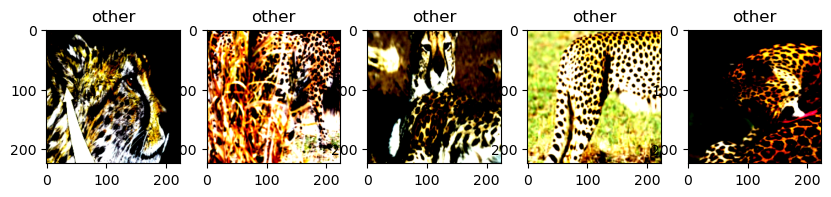

In [7]:
label_names=train_ds.classes
classes={0:'other', 1:'LION'}
fig,axes=plt.subplots(1,5,figsize=(10,4))
for idx,(img_data,target) in enumerate(train_ds):
    axes[idx].imshow(img_data.permute(1,2,0))
    axes[idx].set_title(classes[target])
    if idx==4: break
plt.show()

In [8]:
model=models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

In [9]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
summary(model)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

In [11]:
for named,param in model.named_parameters():
    print(f'[{named}] - {param.shape}')
    
    param.requires_grad=False

[features.0.weight] - torch.Size([64, 3, 3, 3])
[features.0.bias] - torch.Size([64])
[features.2.weight] - torch.Size([64, 64, 3, 3])
[features.2.bias] - torch.Size([64])
[features.5.weight] - torch.Size([128, 64, 3, 3])
[features.5.bias] - torch.Size([128])
[features.7.weight] - torch.Size([128, 128, 3, 3])
[features.7.bias] - torch.Size([128])
[features.10.weight] - torch.Size([256, 128, 3, 3])
[features.10.bias] - torch.Size([256])
[features.12.weight] - torch.Size([256, 256, 3, 3])
[features.12.bias] - torch.Size([256])
[features.14.weight] - torch.Size([256, 256, 3, 3])
[features.14.bias] - torch.Size([256])
[features.17.weight] - torch.Size([512, 256, 3, 3])
[features.17.bias] - torch.Size([512])
[features.19.weight] - torch.Size([512, 512, 3, 3])
[features.19.bias] - torch.Size([512])
[features.21.weight] - torch.Size([512, 512, 3, 3])
[features.21.bias] - torch.Size([512])
[features.24.weight] - torch.Size([512, 512, 3, 3])
[features.24.bias] - torch.Size([512])
[features.26.we

In [12]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [13]:
class VGG16WithFC(nn.Module):
    def __init__(self):
        super(VGG16WithFC, self).__init__()

        self.vgg16 = models.vgg16(pretrained=True)

        self.features=model.features
        self.avgpool=model.avgpool
        self.classifier = self.vgg16.classifier

        self.extra_fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(1000,500),
            nn.ReLU(),
            nn.Linear(500,250),
            nn.ReLU(),
            nn.Linear(250,1)
        )

    def forward(self, x):
        x = self.features(x) 
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)  
        x = self.extra_fc(x)  
        return F.sigmoid(x)

In [14]:
DEVICE='cuda' if torch.cuda.is_available else 'cpu'

In [15]:
model = VGG16WithFC()

c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
print(model)

VGG16WithFC(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [17]:
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
scheduler=lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',patience=10,verbose=True)

c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [18]:
# 사전학습된 모델의 파라미터 비활성화 설정
for named, param in model.named_parameters():
    print(f'[{named}] - {param.shape}')
    # 역전파 시에 업데이트 되지 않도록 설정
    param.requires_grad = False

[vgg16.features.0.weight] - torch.Size([64, 3, 3, 3])
[vgg16.features.0.bias] - torch.Size([64])
[vgg16.features.2.weight] - torch.Size([64, 64, 3, 3])
[vgg16.features.2.bias] - torch.Size([64])
[vgg16.features.5.weight] - torch.Size([128, 64, 3, 3])
[vgg16.features.5.bias] - torch.Size([128])
[vgg16.features.7.weight] - torch.Size([128, 128, 3, 3])
[vgg16.features.7.bias] - torch.Size([128])
[vgg16.features.10.weight] - torch.Size([256, 128, 3, 3])
[vgg16.features.10.bias] - torch.Size([256])
[vgg16.features.12.weight] - torch.Size([256, 256, 3, 3])
[vgg16.features.12.bias] - torch.Size([256])
[vgg16.features.14.weight] - torch.Size([256, 256, 3, 3])
[vgg16.features.14.bias] - torch.Size([256])
[vgg16.features.17.weight] - torch.Size([512, 256, 3, 3])
[vgg16.features.17.bias] - torch.Size([512])
[vgg16.features.19.weight] - torch.Size([512, 512, 3, 3])
[vgg16.features.19.bias] - torch.Size([512])
[vgg16.features.21.weight] - torch.Size([512, 512, 3, 3])
[vgg16.features.21.bias] - torc

In [19]:
for named, param in model.extra_fc.named_parameters():
    print(f'[{named}] - {param.shape}')
    # 역전파 시에 업데이트 되도록 설정
    param.requires_grad = True

[1.weight] - torch.Size([500, 1000])
[1.bias] - torch.Size([500])
[3.weight] - torch.Size([250, 500])
[3.bias] - torch.Size([250])
[5.weight] - torch.Size([1, 250])
[5.bias] - torch.Size([1])


In [20]:
## models 폴더 아래 프로젝트 폴더 아래 모델 파일저장
import os

# 저장 경로
SAVE_PATH = './models1/'
# 저장 파일명
SAVE_FILE = 'lion_model_train_wbs.pth'
# 저장 모델구조 및 파라미터 모두 저장
SAVE_MODEL = 'lion_model_all.pth'

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [21]:
for feature,target in train_dl:
    print(feature.shape,target.shape)
    break


torch.Size([32, 3, 224, 224]) torch.Size([32])


In [22]:
model.to(DEVICE)

epochs=100
loss_history=[]
score_history=[]

for epoch in range(epochs):
    model.train()
    
    epoch_loss=0
    train_pred=[]
    train_true=[]

    for features,targets in train_dl:

        features=features.to(DEVICE)
        targets=targets.to(DEVICE)

        optimizer.zero_grad()

        outputs=model(features.float())
        predicted=torch.round(torch.sigmoid(outputs))
        loss=criterion(outputs,targets.float().view(-1,1)).to(DEVICE)

        loss.backward()
        optimizer.step()

        epoch_loss+=loss.item()
        
        train_pred.extend(predicted.detach().cpu().numpy())
        train_true.extend(targets.detach().cpu().numpy())

    train_f1=f1_score(train_true,train_pred)
    avg_loss_train=epoch_loss/len(train_dl)

    print(f'EPOCH [{epoch+1}/{epochs}]')
    print(f'[TRAIN] Loss: {avg_loss_train}, Score: {train_f1}')

    loss_history.append(avg_loss_train)
    score_history.append(train_f1)

    #최적화 스케줄러
    scheduler.step(loss)
    print()
    print(f'scheduler.num_bad_epochs: {scheduler.num_bad_epochs}',end=' ')
    print(f'scheduler.patience: {scheduler.patience}')
    print()

    if len(score_history) == 1:

        # 첫번째라서 무조건 모델 파라미터 저장
        torch.save(model.state_dict(),SAVE_PATH+SAVE_FILE)

        # 모델 전체 저장
        torch.save(model,SAVE_PATH+SAVE_MODEL)

    else:
        if score_history[-1] >= max(score_history):
            torch.save(model.state_dict(),SAVE_PATH+SAVE_FILE)
            # 모델 전체 저장
            torch.save(model,SAVE_PATH+SAVE_MODEL)

    #손실 감소(성능 개선) 안 되는 경우 조기 종료
    if scheduler.num_bad_epochs >= scheduler.patience:
        print()
        print(f'{scheduler.patience} EPOCH 성능 개선 없어서 조기 종료')
        break

#테스트
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for features, targets in test_dl:

        features=features.to(DEVICE)
        targets=targets.to(DEVICE)

        outputs=model(features.float())
        predicted = torch.round(torch.sigmoid(outputs))
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [1/100]
[TRAIN] Loss: 0.540149631481322, Score: 0.777000777000777

scheduler.num_bad_epochs: 0 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [2/100]
[TRAIN] Loss: 0.516526376444196, Score: 0.9057116953762466

scheduler.num_bad_epochs: 0 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [3/100]
[TRAIN] Loss: 0.5188353156286573, Score: 0.9348335677449602

scheduler.num_bad_epochs: 1 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [4/100]
[TRAIN] Loss: 0.5139246559332288, Score: 0.9354536950420954

scheduler.num_bad_epochs: 0 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [5/100]
[TRAIN] Loss: 0.5192969498180208, Score: 0.9441816461684012

scheduler.num_bad_epochs: 1 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [6/100]
[TRAIN] Loss: 0.5166146040908874, Score: 0.9516051748921898

scheduler.num_bad_epochs: 0 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [7/100]
[TRAIN] Loss: 0.5182474175142864, Score: 0.9522900763358779

scheduler.num_bad_epochs: 1 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [8/100]
[TRAIN] Loss: 0.5156034902920799, Score: 0.957273163706193

scheduler.num_bad_epochs: 2 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [9/100]
[TRAIN] Loss: 0.514216274023056, Score: 0.9519276534983341

scheduler.num_bad_epochs: 3 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [10/100]
[TRAIN] Loss: 0.5194304400966281, Score: 0.9656188605108056

scheduler.num_bad_epochs: 4 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [11/100]
[TRAIN] Loss: 0.5171789432328845, Score: 0.9649464459591043

scheduler.num_bad_epochs: 5 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [12/100]
[TRAIN] Loss: 0.5162956028703659, Score: 0.9603481624758221

scheduler.num_bad_epochs: 6 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [13/100]
[TRAIN] Loss: 0.5147754583093855, Score: 0.9735034347399412

scheduler.num_bad_epochs: 7 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [14/100]
[TRAIN] Loss: 0.5195709774418483, Score: 0.9697270471464019

scheduler.num_bad_epochs: 8 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [15/100]
[TRAIN] Loss: 0.5150009663332076, Score: 0.9749631811487482

scheduler.num_bad_epochs: 9 scheduler.patience: 10



c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH [16/100]
[TRAIN] Loss: 0.5147787096008422, Score: 0.979591836734694

scheduler.num_bad_epochs: 10 scheduler.patience: 10


10 EPOCH 성능 개선 없어서 조기 종료
Accuracy: 0.9643
F1 Score: 0.9661


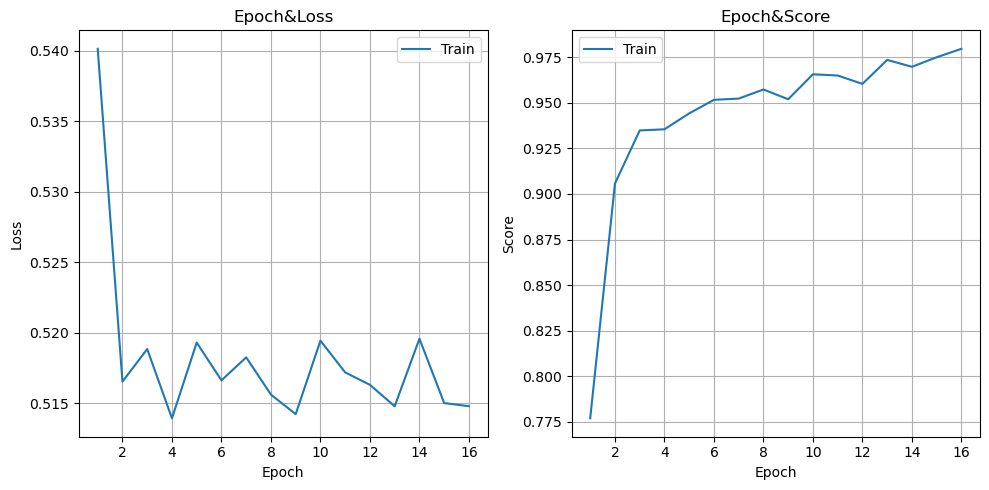

In [29]:
import matplotlib.pyplot as plt

THRESHOLD=len(loss_history)


fg, axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1, THRESHOLD+1), loss_history[:THRESHOLD], label='Train')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Epoch&Loss')

axes[1].plot(range(1, THRESHOLD+1), score_history[:THRESHOLD], label='Train')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title(f'Epoch&Score')
plt.tight_layout()
plt.show()